# Project : Unsupervised Machine Learning (K-Means Clustering by Elbow Method & Silhouette Analysis)

# -------------------------------------------------------------------------------------------------------------

    เป้าหมาย : เพื่อแบ่งกลุ่มลูกค้าของธุรกิจ โดยหาจำนวนกลุ่ม(Clusters) ที่เหมาะสม 
               ด้วยวิธี K- Means clustering โดยใช้  Elbow Method & Silhouette Analysis

# -------------------------------------------------------------------------------------------------------------

# 1. Import Llibrary

In [165]:
# Data
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering Models
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import warnings 
warnings.filterwarnings("ignore")


# 2. Load Dataset

    2.1 โหลด dataset และตั้งชื่อว่า shop_df
    2.2 เปลี่ยนชื่อ column โดยการแทนที่ช่องว่างทั้งหมดในชื่อคอลัมน์ด้วยเครื่องหมายขีดล่าง (_) 

In [166]:
shop_df = pd.read_csv(r"C:\Users\muent\Desktop\my project for data analyst\Project-7_Clustering\Dataset\Shop_Customer_Data.csv")
shop_df.rename(columns= lambda x: x.replace(" ", "_"), inplace=True)
shop_df

,CustomerID,Gender,Age,Annual_Income_(k$),Spending_Score_(1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


มารู้จักแต่ละ column ที่อยู่ใน dataset นี้ว่าประกอบด้วยอะไรบ้าง :

1. CustomerID: รหัสลูกค้า
2. Gender: เพศ
3. Age: อายุ
 4. Annual_Income_(k$): รายได้ต่อปี (หน่วย ดอลล่าห์)
5. Spending_Score_(1-100): คะแนนที่ร้านค้าให้กับลูกค้าตามพฤติกรรมและลักษณะการใช้จ่ายของลูกค้า ตั้งแต่คะแนน 1-100 

# 3. Data Preparation / Data Cleansing

    3.1 เช็ค datatype
    3.2 เปลี่ยน datatype ของ CustomerID จาก integer เป็น string
    3.3 จัดการกับข้อมูลที่หายไป (Missing Value)

In [167]:
shop_df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual_Income_(k$)         int64
Spending_Score_(1-100)     int64
dtype: object

In [168]:
shop_df["CustomerID"] = shop_df["CustomerID"].astype(str)
shop_df.dtypes

CustomerID                object
Gender                    object
Age                        int64
Annual_Income_(k$)         int64
Spending_Score_(1-100)     int64
dtype: object

In [169]:
shop_df.shape

(200, 5)

In [170]:
shop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    object
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual_Income_(k$)      200 non-null    int64 
 4   Spending_Score_(1-100)  200 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 7.9+ KB


In [171]:
shop_df.isnull().sum() #นับค่า Null

CustomerID                0
Gender                    0
Age                       0
Annual_Income_(k$)        0
Spending_Score_(1-100)    0
dtype: int64

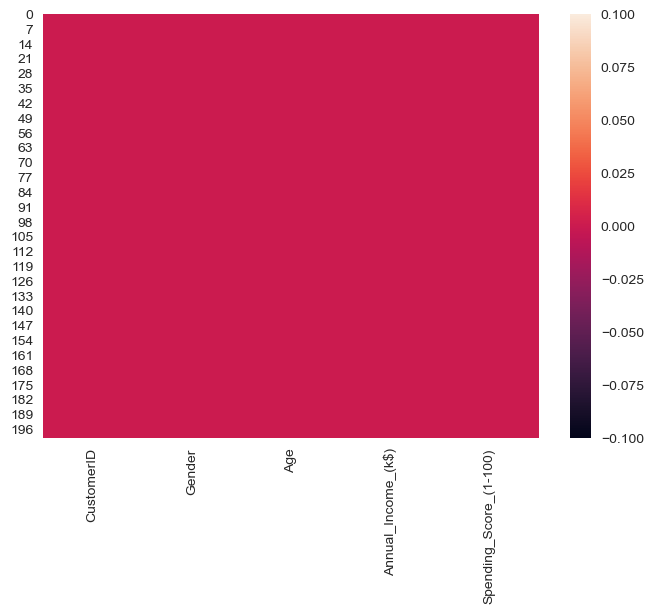

In [172]:
sns.heatmap(shop_df.isnull())
plt.show()

# 4. พล็อตกราฟ histogram เพื่อดูการกระจายตัวของข้อมูลชุดนี้

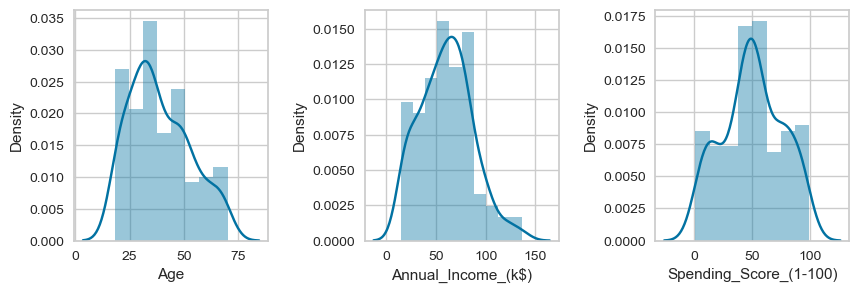

In [173]:
columns = [ 'Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)'] #เอาเฉพาะ column ตัวเลข

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3)) # สร้าง subplot figures
sns.set_style()
for i, column in enumerate(columns): # วนลูปเพื่อพล็อตแต่ละคอลัมน์บน subplot ตามลำดับ
    ax = axes[i]
    sns.distplot(shop_df[column], ax=ax)

plt.subplots_adjust(wspace=0.5) # ปรับแต่งระยะห่างระหว่างกราฟ
plt.show()

In [174]:
shop_df[[ 'Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)']].describe().round(decimals=2)

,Age,Annual_Income_(k$),Spending_Score_(1-100)
count,200.00,200.00,200.00
mean,38.85,60.56,50.20
std,13.97,26.26,25.82
min,18.00,15.00,1.00
25%,28.75,41.50,34.75
50%,36.00,61.50,50.00
75%,49.00,78.00,73.00
max,70.00,137.00,99.00


 1. Age : อายุของลูกค้า
    - ค่า mean > ค่า median จะได้กราฟเบ้ขวา 
    - ลูกค้ามีหลากหลายวัย
2. Annual_Income_(k$) : 
    - ค่า mean < ค่า median จะได้กราฟเบ้ซ้าย
    - รายได้ต่อปีของลูกค้าส่วนใหญ่ จะอยู่ระหว่าง 50K- 85K
3. Spending_Score_(1-100) :  คะแนนที่ร้านค้าให้กับลูกค้า
    - ค่า mean = ค่า median กราฟกระจายตัวปกติ Normal distribution
    - คะแนนที่ร้านค้าให้กับลูกค้าตามพฤติกรรมและลักษณะการใช้จ่ายของลูกค้า ส่วนใหญ่จะอยู่ในช่วง 40 - 60 คะแนน จาก 100 คะแนน

# 5. พล๊อตกราฟ ดู Outlier

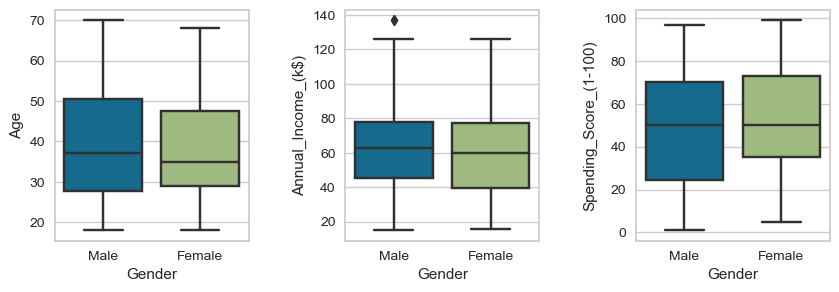

In [175]:
columns = [ 'Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)'] 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3)) 
for i, column in enumerate(columns): 
    ax = axes[i]
    sns.boxplot(data = shop_df, x = "Gender", y = shop_df[column], ax=ax)

plt.subplots_adjust(wspace=0.5) 
plt.show()

# 6. พล๊อตกราฟ pairplot เพื่อดูแต่ละความสัมพันธ์ของข้อมูลแต่ละตัว

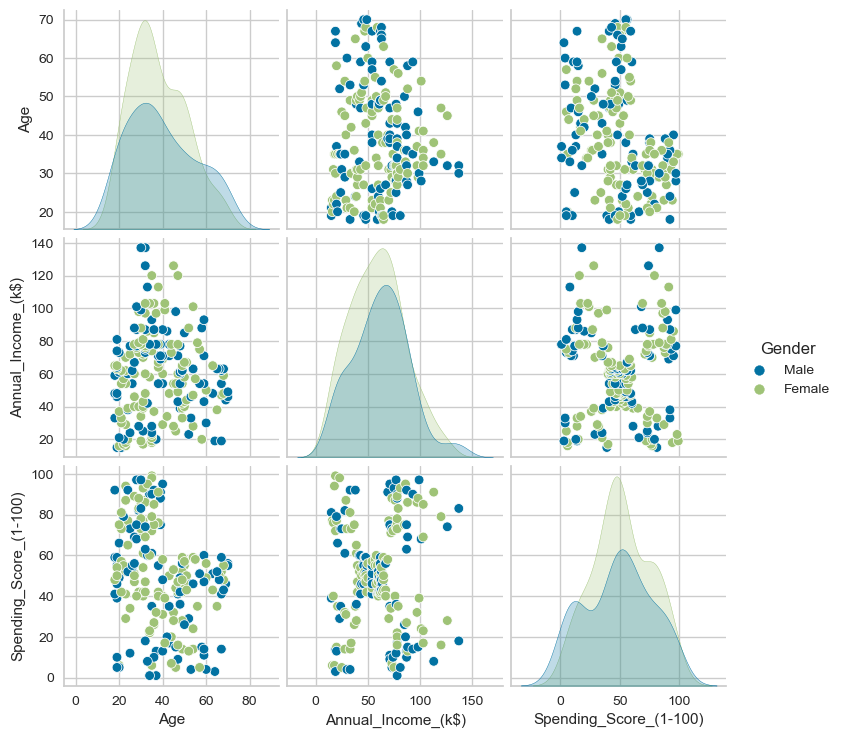

In [176]:
sns.pairplot(shop_df, 
             vars = [ 'Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)'],
             hue = "Gender")
plt.show()

In [177]:
shop_df.groupby(["Gender"])[[ 'Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)']].mean()

,Age,Annual_Income_(k$),Spending_Score_(1-100)
Gender,,,
Female,38.098214,59.250000,51.526786
Male,39.806818,62.227273,48.511364


# 7. พล๊อตกราฟ Correlation เพื่อดูความสัมพันธ์ของข้อมูล

In [178]:
shop_df_corr = shop_df[[ 'Age', 'Annual_Income_(k$)', 'Spending_Score_(1-100)']].corr()
shop_df_corr

,Age,Annual_Income_(k$),Spending_Score_(1-100)
Age,1.000000,-0.012398,-0.327227
Annual_Income_(k$),-0.012398,1.000000,0.009903
Spending_Score_(1-100),-0.327227,0.009903,1.000000


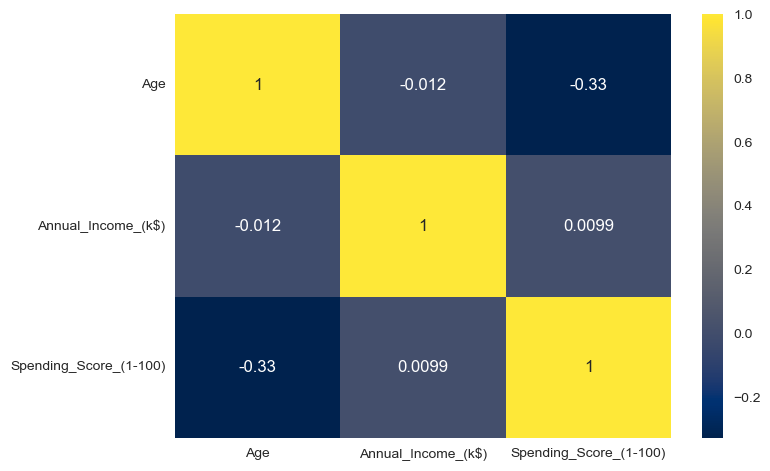

In [179]:
sns.heatmap(shop_df_corr, annot= True, cmap = "cividis")
plt.show()

Correlation คือ ค่าที่บอกว่าข้อมูล 2 ชุดนั้น มีความสัมพันธ์กันหรือไม่ อย่างไร
จะมีค่าอยู่ระหว่าง -1 ถึง 1 โดยที่

    - Strong correlation (Negative) คือ มีค่า correlation เข้าใกล้ -1 
       หมายความว่า ข้อมูลทั้งสองชุดมีความสัมพันธ์กันในเชิงตรงกันข้าม 
       ข้อมูลชุด A เพิ่มขึ้น ส่งผลให้ข้อมูลชุด B ลดลง
       
    - Strong correlation (Positive) คือ มีค่า correlation เข้าใกล้ 1 
       หมายความว่า ข้อมูลทั้งสองชุดมีความสัมพันธ์กันในทิศทางเดียวกัน 
       ข้อมูลชุด A เพิ่มขึ้น ส่งผลให้ข้อมูลชุด B เพิ่มขึ้น 
       
    - Weak correlation คือ มีค่า correlation เข้าใกล้ 0 
       หมายความว่า ข้อมูล 2 ชุด มีความสัมพันธ์กันต่ำ หาความสัมพันธ์กันแทบจะไม่ได้ 
       ** ถ้าข้อมูลไม่มีความสัมพันธ์ใดๆ ต่อกันเลย ค่า Correlation จะเท่ากับ 0)

    แปลผลของกราฟ pairplot และกราฟ correlation 
    แล้วพบว่า
    - ความสัมพันธ์ของ Age กับ Spending_Score_(1-100)  มีค่า correlation = -0.33  
    ซึ่งเข้าใกล้ -1  ข้อมูลมีความสัมพันธ์กันในทิศทางตรงกันข้าม  
    
    -  ความสัมพันธ์ของ Annual_Income_(k$) กับ Spending_Score_(1-100)  มีค่า correlation = 0.0099 
    ซึ่งเข้าใกล้ 1 ข้อมูลมีความสัมพันธ์กันในทิศทางเดียวกัน
            
    - ความสัมพันธ์ของ Age กับ Annual_Income_(k$) มีค่า correlation = -0.012 
    ซึ่งเข้าใกล้ - 1 ข้อมูลมีความสัมพันธ์กันในทิศทางตรงกันข้าม 

    ดังนั้นเมื่อดูจากกราฟทั้งสองแล้ว ข้อมูลที่จะนำไป clustering คือ 
        1. ข้อมูลชุดที่ 1 = Annual_Income_(k$) กับ Spending_Score_(1-100) 
        2. ข้อมูลชุดที่ 2 = Age กับ Spending_Score_(1-100) 

# 8. วิเคราะห์ข้อมูล (Data Analysis)

    - กำหนดให้ X1 คือ ข้อมูลชุดที่ 1 ซึ่งประกอบไปด้วย Annual_Income_(k$) กับ Spending_Score_(1-100) 
    - กำหนดให้ X2 คือ ข้อมูลชุดที่ 2 ซึ่งประกอบไปด้วย Age กับ Spending_Score_(1-100) 

In [180]:
# X1 คือ ข้อมูลชุดที่ 1 
X1 = shop_df[['Annual_Income_(k$)', 'Spending_Score_(1-100)']]

# X2 คือ ข้อมูลชุดที่ 2
X2 = shop_df[['Age', 'Spending_Score_(1-100)']]

print(f'ข้อมูลชุดที่ 1 (5 แถวแรก):\n {X1.head(5)}\n')
print(f'ข้อมูลชุดที่ 2 (5 แถวแรก):\n {X2.head(5)}\n')

ข้อมูลชุดที่ 1 (5 แถวแรก):
    Annual_Income_(k$)  Spending_Score_(1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40

ข้อมูลชุดที่ 2 (5 แถวแรก):
    Age  Spending_Score_(1-100)
0   19                      39
1   21                      81
2   20                       6
3   23                      77
4   31                      40



# 9.  Data standardization ข้อมูล

In [181]:
scaler = StandardScaler()
#Data standardization ข้อมูลชุดที่ 1
X1_scaled = scaler.fit_transform(X1)

#Data standardization ข้อมูลชุดที่ 2
X2_scaled = scaler.fit_transform(X2)

#numpy.ndarray
#การพิมพ์ 5 แถวแรกของอาร์เรย์ผลลัพธ์ ให้ใช้ slicing อาร์เรย์ด้วย [:5,] แทนการใช้ head(5) ซึ่งจะทำงานกับ DataFrame ของ pandas เท่านั้น

print(f'Data standardization ข้อมูลชุดที่ 1 (5 แถวแรก):\n {X1_scaled[:5,]}\n')
print(f'Data standardization ข้อมูลชุดที่ 2 (5 แถวแรก):\n {X2_scaled[:5,]}\n')  

Data standardization ข้อมูลชุดที่ 1 (5 แถวแรก):
 [[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]

Data standardization ข้อมูลชุดที่ 2 (5 แถวแรก):
 [[-1.42456879 -0.43480148]
 [-1.28103541  1.19570407]
 [-1.3528021  -1.71591298]
 [-1.13750203  1.04041783]
 [-0.56336851 -0.39597992]]



# 10. หาจำนวนคลัสเตอร์ (k)ที่เหมาะสม จาก วิธี Elbow Method และ วิธี Silhouette Analysis ร่วมกัน

    concept: 
        1. หาจำนวนคลัสเตอร์ (k)ที่เหมาะสม จาก วิธี Elbow Method
        2. พล็อตกราฟระหว่าง inertia และ k 
        3. พล็อตเส้นตรงแนวดิ่งตัดจุดหักศอก elbow พอดี จาก library kneed ( from kneed import KneeLocator)
        4. อ่านค่า k ที่จัดตัดนั้น 
        5. พล็อตกราฟ Silhouette 
        6. เลือกค่า optimal k 

# Elbow Method

Function find_optimal_k รับพารามิเตอร์ 2 ตัว:

    X_scaled: ข้อมูลที่จะใช้ในการหาค่า k ที่เหมาะสม
    title: ชื่อที่จะแสดงในกราฟ

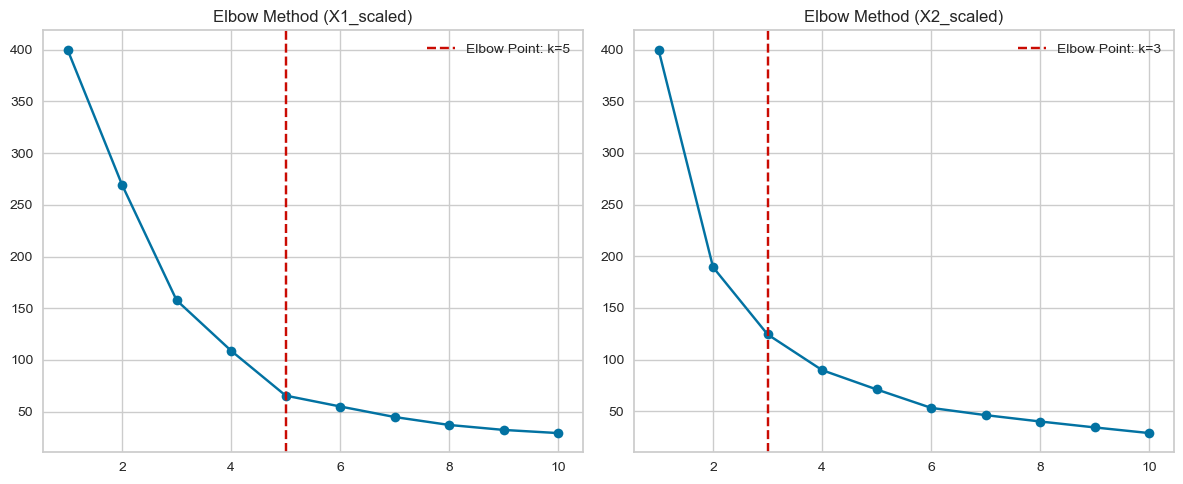

In [182]:
def find_optimal_k(X_scaled, title):
    inertia = []
    k_range = range(1, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=88)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # Find the knee (elbow) using kneed library
    kn = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
    elbow_point = kn.knee

    return k_range, inertia, elbow_point

#พล็อตกราฟ 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#พล็อตกราฟของข้อมูลชุดที่ 1 
k_range_X1, inertia_X1, elbow_point_X1 = find_optimal_k(X1_scaled, 'X1_scaled')
ax1.plot(k_range_X1, inertia_X1, marker='o')
ax1.axvline(x=elbow_point_X1, color='r', linestyle='--', label=f'Elbow Point: k={elbow_point_X1}')#พล็อตจุดตัด elbow
ax1.set_title('Elbow Method (X1_scaled)')
ax1.legend()

#พล็อตกราฟของข้อมูลชุดที่ 2
k_range_X2, inertia_X2, elbow_point_X2 = find_optimal_k(X2_scaled, 'X2_scaled')
ax2.plot(k_range_X2, inertia_X2, marker='o')
ax2.axvline(x=elbow_point_X2, color='r', linestyle='--', label=f'Elbow Point: k={elbow_point_X2}') #พล็อตจุดตัด elbow
ax2.set_title('Elbow Method (X2_scaled)')
ax2.legend()

plt.tight_layout() #ปรับขนาดของกราฟให้เหมาะสม
plt.show()


# Calculate silhouette score 

Function plot_silhouette_coefficients รับพารามิเตอร์ 2 ตัว:

    X_scaled: ข้อมูลที่จะใช้ในการหาค่า Silhouette Coefficients
    title: ชื่อที่จะแสดงในกราฟ

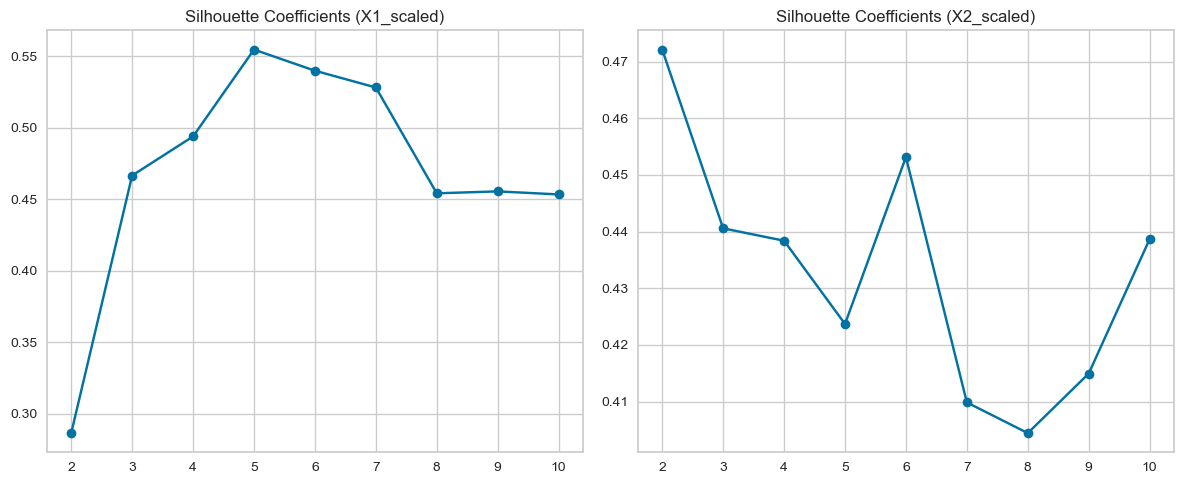

In [183]:
def plot_sil_coef(X_scaled, title):
    sil_coefs = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=88)
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')
        sil_coefs.append(score)
    
    return k_range, sil_coefs

#พล็อตกราฟ 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#พล็อตกราฟของข้อมูลชุดที่ 1 
k_range_X1, sil_coef_X1 = plot_sil_coef(X1_scaled, 'X1_scaled')
ax1.plot(k_range_X1, sil_coef_X1, marker='o')
ax1.set_title('Silhouette Coefficients (X1_scaled)')

#พล็อตกราฟของข้อมูลชุดที่ 2 
k_range_X2, sil_coef_X2 = plot_sil_coef(X2_scaled, 'X2_scaled')
ax2.plot(k_range_X2, sil_coef_X2, marker='o')
ax2.set_title('Silhouette Coefficients (X2_scaled)')

plt.tight_layout() #ปรับขนาดของกราฟให้เหมาะสม
plt.show()

# Silhouette Visualizer

Function plot_silhouette รับพารามิเตอร์ 2 ตัว:

    X_scaled: ข้อมูลที่จะใช้ในการพล็อต Silhouette Plot
    title: ชื่อที่จะแสดงในกราฟ

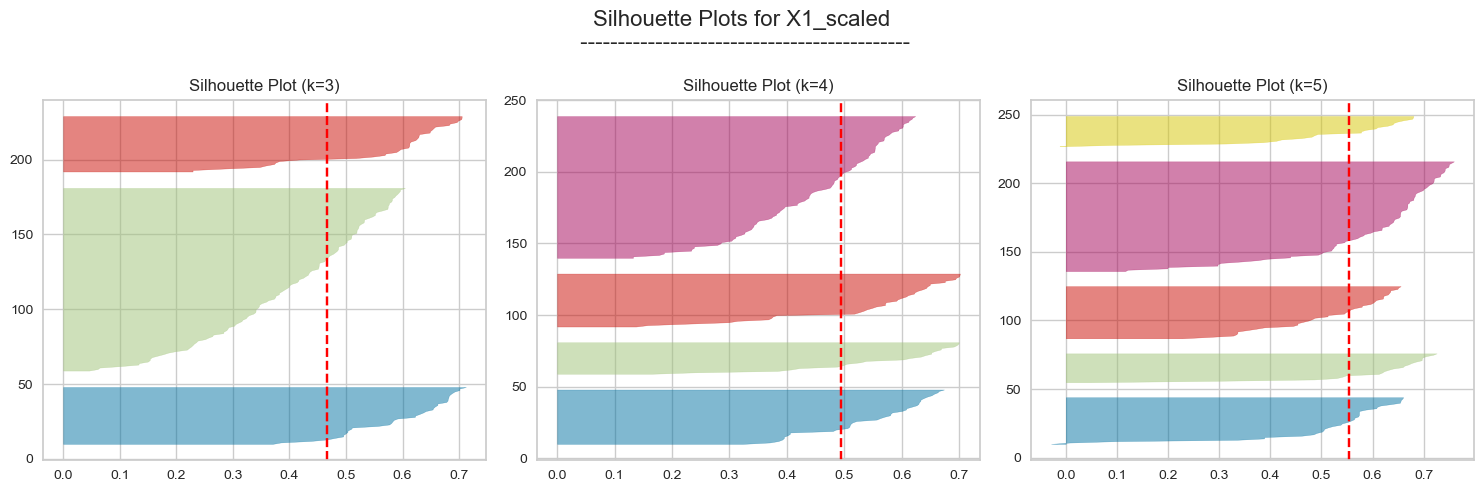

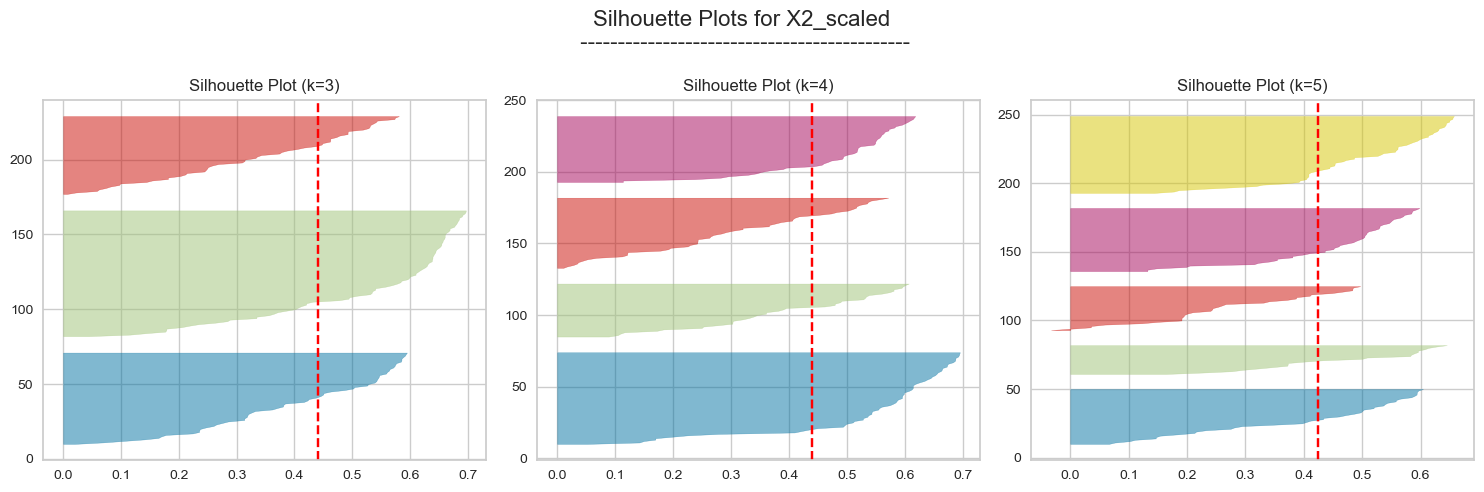

In [184]:
def plot_sil_Visualizer(X_scaled, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, k in enumerate(range(3, 6)):
        model = KMeans(n_clusters=k, init='k-means++', random_state=88)
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[i])
        visualizer.fit(X_scaled)
        axes[i].set_title(f"Silhouette Plot (k={k})")
        
    fig.suptitle(f"Silhouette Plots for {title}\n --------------------------------------------", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sil_Visualizer(X1_scaled, 'X1_scaled')
plot_sil_Visualizer(X2_scaled, 'X2_scaled')

1. พิจารณาข้อมูลชุดที่ 1 : X1_scaled
    - สรุปกราฟ Elbow Method ค่า k = 5 
    - และ กราฟ Silhouette Score  จะเห็นว่า เมื่อแบ่ง cluster เกิน 5 cluster ค่า silhouette ลดลงเรื่อยๆ
       แสดงว่าเมื่อแบ่ง cluster เกิน 5 เป็นการแบ่งที่ไม่ค่อยเหมาะสมแล้ว
       เพราะทำให้ ค่า silhouette มีค่าเข้าใกล้ -1 มากขึ้น
    - กราฟ Silhouette Visualizer อาจจะเป็น k = 4 หรือ k = 5  เพราะไม่มีคะแนน Silhouette score ของคลัสเตอร์ใดต่ำกว่า ค่าเฉลี่ย
    - ขนาดของพล็อตแต่ละคลัสเตอร์ แต่ k = 5 ไม่แตกต่างกันมาก ในขณะที่ k = 4 กลุ่มคลัสเตอร์ที่ 1 มีขนาดใหญ่เกินกลุ่มอื่นมากไป
      ดังนั้น ค่า k= 5 เหมาะสมที่สุด 
    
      ดังนั้น เมื่อพิจารณาประกอบกับค่าที่ได้จาก elbow method และ  Silhouette Score และ Silhouette Visualizer
           ค่า k = 5 จึงเป็นค่าที่เหมาะสม
           โดยต่อไปจะทำการรัน k-mean โดยใช้ ค่า k = 5 สำหรับข้อมูลชุดที่1

2. พิจารณาข้อมูลชุดที่ 2 : X2_scaled
    - สรุปกราฟ Elbow Method ค่า k = 3
    - และ กราฟ Silhouette Score จะเห็นว่า เมื่อแบ่ง cluster เกิน 3 cluster ค่า silhouette ลดลงเรื่อยๆ เพราะทำให้ ค่า silhouette มีค่าเข้าใกล้ -1 มากขึ้น
    - แล้วไปเพิ่มเป็น 6 แสดงว่าค่า k อาจจะเป็นค่าที่อยู่ระหว่าง 3 ถึง 6 
    - กราฟ Silhouette Visualizer ค่า k= 4 เหมาะสมที่สุด เพราะไม่มีคะแนน Silhouette score ของคลัสเตอร์ใดต่ำกว่า ค่าเฉลี่ย
    - ขนาดของพล็อตแต่ละคลัสเตอร์ไม่แตกต่างกันมาก
    
      ดังนั้น เมื่อพิจารณาประกอบกับค่าที่ได้จาก elbow method และ  Silhouette Score และ Silhouette Visualizer
           ค่า k = 4  จึงเป็นค่าที่เหมาะสม
           โดยต่อไปจะทำการรัน k-mean โดยใช้ ค่า k = 4 สำหรับข้อมูลชุดที่ 2 

สรุป การหาค่า k ที่เหมาะสม
- ข้อมูลชุดที่ 1 : X1_scaled  จะได้ค่า k = 5 , ควรแบ่งข้อมูลออกเป็น 5 กลุ่ม
    
- ข้อมูลชุดที่ 2 : X2_scaled  จะได้ค่า k = 4 , ควรแบ่งข้อมูลออกเป็น 4 กลุ่ม

# 11.  สร้าง Model เพื่อกำหนดเลข cluster ให้แต่ละ data point

    concept: 
        1. นำค่า k มาทำการ fit_predict() 
        2. เก็บค่า cluster labels เพื่อระบุเลขกลุ่มให้แต่ละ data point
        3. เก็บค่า centroid ของแต่ละกลุ่ม 
        4. Inverse transform centroid values เปลี่ยนค่า centroid กลับไป fit กับข้อมูลตั้งต้น เพื่อเอาไว้พล็อตกราฟแสดงจุด centroid ของแต่ละคลัสเตอร์

ฟังก์ชัน cluster_data รับพารามิเตอร์ 3 ตัว:

    X_scaled: ข้อมูลที่จะใช้ในการทำ Clustering
    n_clusters: จำนวน cluster ของแต่ละชุดข้อมูล เช่น ข้อมูลชุดที่1 k = 5 , ข้อมูลชุดที่1 k = 4 
    title: ชื่อที่จะแสดงในผลลัพธ์

    11.1 นำค่า k มาทำการ fit_predict() 
    11.2 เก็บค่า cluster labels เพื่อระบุเลขกลุ่มให้แต่ละ data point

In [185]:
# ข้อมูลชุดที่ 1  X1_scaled, k = 5

kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=88)
kmeans1.fit_predict(X1_scaled)
cluster_label_X1_scaled = kmeans1.labels_ + 1  # +1 เพื่อให้ cluster label เริ่มจากเลข 1 
print(f'cluster_label_X1_scaled : {cluster_label_X1_scaled}' )

cluster_label_X1_scaled : [5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5
 2 5 2 5 2 5 4 5 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 3 1 3 4 3 1 3 1 3 4 3 1 3 1 3 1 3 1 3 4 3 1 3 1 3
 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1
 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3]


In [186]:
# ข้อมูลชุดที่ 2  X2_scaled, k = 4

kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=88)
kmeans2.fit_predict(X2_scaled)
cluster_label_X2_scaled = kmeans2.labels_ + 1  # +1 เพื่อให้ cluster label เริ่มจากเลข 1 
print(f'cluster_label_X2_scaled : {cluster_label_X2_scaled}' )

cluster_label_X2_scaled : [3 1 3 1 3 1 2 1 2 1 2 1 2 1 2 1 3 1 2 1 3 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 3 1 4 1 4 1 2 1 4 3 3 3 4 1 3 4 4 4 4 4 3 4 4 3 4 4 4 3 4 4 3 3 4 4 4 4
 4 3 4 3 3 4 4 3 4 4 3 4 4 3 1 4 4 3 4 3 3 3 4 3 4 3 3 4 4 3 4 3 4 4 4 4 4
 3 3 3 3 3 4 4 4 4 3 3 1 1 3 1 2 1 2 1 2 1 3 1 3 1 2 1 3 1 2 1 3 1 3 1 4 1
 3 1 2 1 2 1 2 1 2 1 2 1 4 1 3 1 2 1 2 1 3 1 2 1 2 1 2 1 2 1 2 1 3 1 2 1 3
 1 2 1 2 1 3 1 2 1 2 1 2 1 3 1]


    11.3 เก็บค่า centroid ของแต่ละกลุ่ม 

In [187]:
# centroids ของข้อมูลชุดที่ 1  X1_scaled, k = 5
centroids_X1_scaled = kmeans1.cluster_centers_
print(f'centroids_X1_scaled: {centroids_X1_scaled}')

# centroids ของข้อมูลชุดที่ 2  X2_scaled, k = 4
centroids_X2_scaled = kmeans2.cluster_centers_
print(f'centroids_X2_scaled: {centroids_X2_scaled}')

centroids_X1_scaled: [[ 1.05500302 -1.28443907]
 [-1.32954532  1.13217788]
 [ 0.99158305  1.23950275]
 [-0.20091257 -0.02645617]
 [-1.30751869 -1.13696536]]
centroids_X2_scaled: [[-0.61415725  1.14971545]
 [ 0.62833625 -1.36651894]
 [-0.8346466  -0.39442706]
 [ 1.22927178 -0.06558366]]


       11.4 Inverse transform centroid values เปลี่ยนค่า centroid กลับไป fit กับข้อมูลตั้งต้น 
              เพื่อเอาไว้พล็อตกราฟแสดงจุด centroid ของแต่ละคลัสเตอร์

In [188]:
# centroids original ของข้อมูลชุดที่ 1 
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
centroid_original_X1_scaled = scaler.inverse_transform(kmeans1.cluster_centers_)
print(f'Original Centroids_X1_scaled: {centroid_original_X1_scaled}')

# centroids original ของข้อมูลชุดที่ 2 
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)
centroid_original_X2_scaled = scaler.inverse_transform(kmeans2.cluster_centers_)
print(f'Original Centroids_X2_scaled: {centroid_original_X2_scaled}')

Original Centroids_X1_scaled: [[88.2        17.11428571]
 [25.72727273 79.36363636]
 [86.53846154 82.12820513]
 [55.2962963  49.51851852]
 [26.30434783 20.91304348]]
Original Centroids_X2_scaled: [[30.29230769 79.81538462]
 [47.60526316 15.        ]
 [27.22       40.04      ]
 [55.9787234  48.5106383 ]]


# 12. เก็บค่า cluster label ใส่ dataframe ที่ชื่อว่า shop_df

    12.1 เก็บค่า cluster_label_X1_scaled 
        ชื่อว่า AnnualIncome_SpendingScore_Cluster

    12.2 เก็บค่า cluster_label_X2_scaled 
        ชื่อว่า Age_SpendingScore_Cluster

In [189]:
shop_df["AnnualIncome_SpendingScore_Cluster"] = cluster_label_X1_scaled 
shop_df["Age_SpendingScore_Cluster"] = cluster_label_X2_scaled 
shop_df

,CustomerID,Gender,Age,Annual_Income_(k$),Spending_Score_(1-100),AnnualIncome_SpendingScore_Cluster,Age_SpendingScore_Cluster
0,1,Male,19,15,39,5,3
1,2,Male,21,15,81,2,1
2,3,Female,20,16,6,5,3
3,4,Female,23,16,77,2,1
4,5,Female,31,17,40,5,3
...,...,...,...,...,...,...,...
195,196,Female,35,120,79,3,1
196,197,Female,45,126,28,1,2
197,198,Male,32,126,74,3,1
198,199,Male,32,137,18,1,3


In [190]:
shop_df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual_Income_(k$)',
       'Spending_Score_(1-100)', 'AnnualIncome_SpendingScore_Cluster',
       'Age_SpendingScore_Cluster'],
      dtype='object')

# 13. พล็อตกราฟ

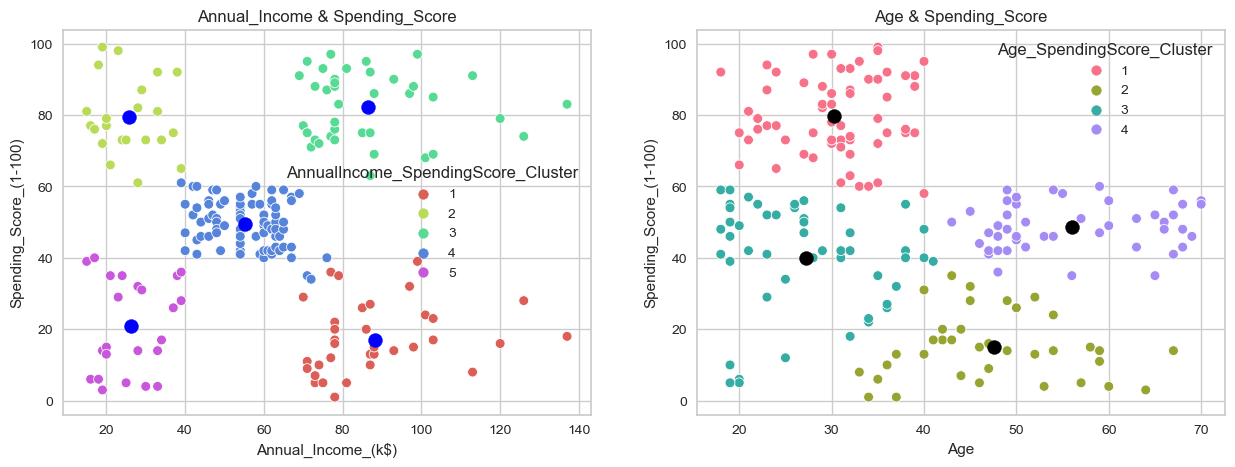

In [191]:
data = shop_df[['Age', 'Annual_Income_(k$)','Spending_Score_(1-100)']]

plt.figure(figsize=(15,5))

#กราฟข้อมูลชุดที่ 1 Annual_Income & Spending_Score
plt.subplot(1,2,1)
sns.scatterplot(x = shop_df["Annual_Income_(k$)"], y = shop_df["Spending_Score_(1-100)"], data = data, s=50, hue=shop_df["AnnualIncome_SpendingScore_Cluster"], palette=sns.color_palette("hls", 5))
plt.title("Annual_Income & Spending_Score")

# Plot the centroids
plt.scatter(centroid_original_X1_scaled[:,0], centroid_original_X1_scaled[:,1], c='blue', s=100)

#-----------------------------------

#กราฟข้อมูลชุดที่ 2 Age & Spending_Score
plt.subplot(1,2,2)
sns.scatterplot(x = shop_df["Age"], y = shop_df["Spending_Score_(1-100)"], data = data, s=50, hue=shop_df["Age_SpendingScore_Cluster"], palette=sns.color_palette("husl", 4))
plt.title("Age & Spending_Score")
    
#Plot the centroids
plt.scatter(centroid_original_X2_scaled[:,0], centroid_original_X2_scaled[:,1], c='black', s=100)

plt.show()

# 14. สรุปผล

    1. เมื่อพิจารณาความสัมพันธ์ของ Annual_Income_(k$)  และ Spending_Score_(1-100) คือ การแบ่งกลุ่มลูกค้าตามรายได้และพฤติกรรมการซื้อ
        จะจัดกลุ่มลูกค้าออกมาได้ 5 กลุ่ม 
        โดยที่แต่ละกลุ่มมีลักษณะ ดังนี้
    - cluster 1 : มีรายได้ต่อปีสูง ,แต่ไม่ค่อยซื้อสินค้าเลย 
                     เป็นคนที่คิดก่อนซื้อ กลุ่มคนที่ใส่ใจรายละเอียด (Smart Buyer)  
                     ต้องให้บริการด้านข้อมูลเกี่ยวกับสินค้ามากๆเพื่อให้ลูกค้าได้ตัดสินใจซื้อด้วยความเชื่อมั่นในข้อมูล
    - cluster 2 : มีรายได้ต่อปีต่ำ , แต่ชอบซื้อสินค้ามากๆ 
                     ลูกค้าอาจจะอยากซื้อแต่ต้องประหยัดเงินด้วย 
                     ธุรกิจอาจจะต้องจัดโปรสุดคุ้ม ดึงดูดได้ด้วยโปรโมชัน (Persuadable) เช่น ส่วนลด cross sell
    - cluster 3 : มีรายได้ต่อปีสูง , ชอบซื้อสินค้ามากๆเช่นกัน 
                     เรียกได้ว่ากลุ่มนี้คือ Customer Loyalty  
                     ลูกค้าประเภทนี้มักช่วยบอกต่อ พวกเขาจะแนะนำธุรกิจหรือผลิตภัณฑ์ให้กับเพื่อนๆ และครอบครัวอย่างจริงใจ
    - cluster 4 : มีรายได้ต่อปีปานกลาง , ชอบซื้อสินค้าปานกลาง
                     จะชอบซื้อสินค้าตามโปรโมชั่น กังวลเรื่องราคาอยากได้ราคาที่คุ้มค่าที่สุด 
                     ชอบดูรีวิวก่อนซื้อ เพื่อให้มั่นใจว่าสินค้านั้นดีจริง และทำให้ไม่เสียค่าใช้จ่ายโดยสูญเปล่า
    - cluster 5 : มีรายได้ต่อปีต่ำ , และไม่ค่อยซื้อสินค้า
                      เป็นกลุ่มที่ชอบซื้อสินค้าราคาไม่แพง ชอบโปรลด ของแถม อาจจะจัดโปรช่วงล้างสต๊อกด้วยโปรแรงๆ 
                      หรือให้ช่วยแชร์กิจกรรมของธุรกิจเพื่อแลกรับของแถม

    2. เมื่อพิจารณาความสัมพันธ์ของ Age  และ Spending_Score_(1-100) คือ การแบ่งกลุ่มลูกค้าตามอายุและพฤติกรรมการซื้อ
        จะจัดกลุ่มลูกค้าออกมาได้ 4 กลุ่ม 
        โดยที่แต่ละกลุ่มมีลักษณะ ดังนี้
    - cluster 1 : อายุช่วง 20-40, ชอบซื้อสินค้ามากๆ
    - cluster 2 : อายุช่วง 30-70, ไม่ค่อยซื้อสินค้าเลย
    - cluster 3 : อายุช่วง 20-40, ซื้อสินค้าน้อยถึงปานกลาง
    - cluster 4 : อายุช่วง 40-70, ซื้อสินค้าในระดับปานกลาง

     บทสรุป :        
         แต่ละธุรกิจจำเป็นต้องเข้าใจประเภทของลูกค้าแต่ละกลุ่ม 
    ทั้งนี้เพื่อจะได้ทำการตลาดและขายผลิตภัณฑ์หรือบริการได้อย่างมีประสิทธิภาพ 
        การบริการได้ตรงความต้องการและตอบโจทย์ความชื่นชอบของลูกค้าได้ดียิ่งขึ้น สิ่งนี้สามารถนำไปสู่การเพิ่มความพึงพอใจของลูกค้า ความภักดี 
    และท้ายที่สุด คือ ยอดขายที่เพิ่มขึ้น
    นอกจากนี้ การทำความเข้าใจพฤติกรรมและความชอบของลูกค้าในแต่ละกลุ่มที่แตกต่างกัน 
    สามารถช่วยธุกิจต่างๆ ในการตัดสินใจเกี่ยวกับการพัฒนาผลิตภัณฑ์ กลยุทธ์การกำหนดราคา และช่องทางการจัดจำหน่าย เพื่อส่งเสริมให้ธุรกิจเติบโตอย่างยั่งยืน